In [1]:
from convexness.convexness import *
import glob
import os
import open3d as o3d
import pandas as pd
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
n_random_samples = 1

In [3]:
def process_our_folder(folder):
    target_extension = '.obj'
    metadata_pattern = '*_mesh.txt'
    path = folder + '*/' + metadata_pattern
    mesh_files = glob.glob(folder + '*/' + metadata_pattern, recursive=True)
    
    #
    global_df = None
    
    for metadata_file in tqdm(mesh_files):
        df = pd.read_csv(metadata_file, sep='\t', header=0, index_col=False)
        
        # maintain only a subset of the columns
        df = df[['Filename', 'Percentage', 'Vertices', 'Faces']]
        if global_df is None:
            global_df = df
        else:
            global_df = pd.concat([global_df, df], ignore_index=True)
            
    # create a new column with the number of fragments
    global_df['Fragments'] = global_df['Filename'].apply(lambda x: int(x.split('f_')[0].split('_')[-1]))
    # select 1000 random samples from fragments with 4 or less fragments
    global_df = global_df[global_df['Fragments'] <= 10]
    global_df = global_df.sample(n=n_random_samples)

    # iterate to calculate the convexness
    for index, row in global_df.iterrows():
        filename = row['Filename']
        filename = filename.replace('E:/Fragments/', 'C:/Users/PC-157/Documents/Datasets/')
        
        mesh = trimesh.load_mesh(filename)
        # normalize the mesh
        mesh.vertices -= mesh.vertices.mean(axis=0)
        mesh.vertices /= np.abs(mesh.vertices).max()
        
        convexness = measure_convexness(mesh, 100, 1)
        global_df.loc[index, 'Convexness'] = convexness
        
    return global_df

In [4]:
def process_voronoi_folder(folder):
    target_extension = '.obj'
    files = glob.glob(folder + '*/*' + target_extension, recursive=True)
    # random sample
    random_indices = np.random.choice(len(files), n_random_samples, replace=False)
    files = [files[i] for i in random_indices]
    
    global_df = pd.DataFrame(columns=['Filename', 'Fragments'])  
    for file in tqdm(files):
        file_name = os.path.basename(file)
        fragments = int(file_name.split('_')[0])
        global_df = pd.concat([global_df, pd.DataFrame({'Filename': [file], 'Fragments': [fragments]})], ignore_index=True)
        
        # read the mesh 
        mesh = trimesh.load_mesh(file)
        # normalize the mesh
        mesh.vertices -= mesh.vertices.mean(axis=0)
        mesh.vertices /= np.abs(mesh.vertices).max()
        
        convexness = measure_convexness(mesh, 100, 1)
        global_df.loc[global_df['Filename'] == file, 'Convexness'] = convexness
        
    return global_df

In [5]:
#folders = ['D:/allopezr/Fragments/Vessels_200_Voronoi/', 'D:/allopezr/Fragments/vessels_200_obj_ply_no_zipped/vessels_200_obj_ply/']

folders = ['C:/Users/PC-157/Documents/Datasets/Vessels_200_CellFracture/', 'C:/Users/PC-157/Documents/Datasets/vessels_200_obj_ply/']

results = []

for folder in tqdm(folders):
    if 'CellFracture' in folder:
        global_df = process_voronoi_folder(folder)
    else:
        global_df = process_our_folder(folder)      
    results.append(global_df[['Fragments', 'Convexness']])

100%|██████████| 2/2 [00:19<00:00,  9.76s/it]


In [6]:
results

[  Fragments  Convexness
 0         9    0.776765,
         Fragments  Convexness
 175625          9    0.361818]

In [9]:
import matplotlib.pyplot as plt

# Change matplotlib style
plt.style.use('default')

font_mapping = {'family': 'Adobe Devanagari', 'weight': 'normal', 'size': 17}
plt.rc('font', **font_mapping)

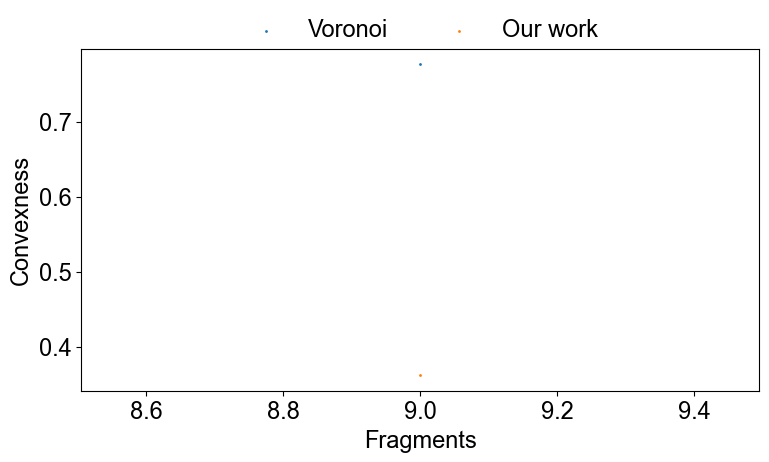

In [12]:
# render the results
import matplotlib.pyplot as plt

legends = ['Voronoi', 'Our work']

plt.figure(figsize=(8, 5))

for df, legend in zip(results, legends):
    plt.scatter(df['Fragments'], df['Convexness'], s=1, label=legend)

for df in results:
    # interpolate the data
    x = df['Fragments']
    y = df['Convexness']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), '--')

plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.xlabel('Fragments')
plt.ylabel('Convexness')
# x ticks as int
# plt.xticks(np.arange(2, 6, 1))
plt.tight_layout()
plt.show()

In [ ]:
# percentil 75, 50, 25
for df in results:
    print(df['Convexness'].quantile([0.25, 0.5, 0.75]))